In [1]:
import os 
import glob 
from tqdm import tqdm

import torch
import pandas as pd
import numpy as np
import skimage.metrics 
from torchmetrics.functional.classification import dice, recall, precision
from torchmetrics import Dice, Recall, Precision 
import nibabel as nib 

In [2]:
def binarize_image(img, threshold = 0.5, one_hot = False):
    if img.ndim == 4:
       img = img.unsqueeze(0)

    elif img.ndim == 3:
        img = img[None, None, :, :, :]

    assert img.ndim == 5, f'Binarize_image, tensor mismatch {img.shape}'

    n_channels = img.shape[1]

    # binary problem
    if n_channels == 1:
        nimg = img > threshold
    elif n_channels == 3:
        if img.dtype == torch.bool:
            nimg = img.float()
        else:
            nimg           = torch.zeros_like(img)
            argmax_indexes = torch.argmax(img, dim = 1)
            nimg.scatter_(1, argmax_indexes.unsqueeze(1), 1) 
    else:
        print(f"In binarize_image, number of channels {n_channels}")
    
    if nimg.dtype != torch.float:   nimg = nimg.float()
    
    return nimg

def calculate_overlap_metrics(pred, gt, target_label: int == 1):
    aneur_mask      = torch.where(gt == target_label, 1, 0)
    pred_image_bin  = binarize_image(pred)
    pred_aneur_mask = torch.mul(pred_image_bin, aneur_mask)

    # compute dice score recall and precision
    tp = torch.sum((pred_aneur_mask == 1) & (aneur_mask == 1))
    fp = torch.sum((pred_aneur_mask == 1) & (aneur_mask == 0))
    fn = torch.sum((pred_aneur_mask == 0) & (aneur_mask == 1))

    if 2*tp + fp + fn == 0: dice_aneur = 1e-12
    else: dice_aneur = (2*tp/(2*tp + fp + fn)).item()

    if tp + fn == 0: recall_aneur = 1e-12
    else: recall_aneur = (tp/(tp+fn)).item()

    if fp + tp == 0: precision_aneur = 1e-12
    else: precision_aneur = (tp/(tp+fp)).item()
    metrics = {'dice_aneur':dice_aneur, 
               'recall_aneur':recall_aneur, 
               'precision_aneur':precision_aneur}
    
    return metrics

In [4]:
def calculate_metrics(num_classes, aneurysm_class, gt_vols_fp, pred_vols_fn):
    dice = Dice(num_classes=num_classes, ignore_index=0, average='micro')
    recall = Recall(num_classes=num_classes, ignore_index=0, average='micro', task='binary')
    precision = Precision(num_classes=num_classes, ignore_index=0, average='micro', task='binary')
    
    metrics_tm = {'dice': dice, 'recall': recall, 'precision': precision}
    results = []
    for gt_vol_fp in tqdm(gt_vols_fp):
        vol_fn = os.path.basename(gt_vol_fp)
    
        try:
            assert vol_fn in pred_vols_fn, \
                f"No prediction for vol {vol_fn}"
        except AssertionError as e:
            print(e)
            continue
        
        # load vols     
        gt = nib.load(gt_vol_fp).get_fdata()
        gt = torch.tensor(gt).float()
        
        pred = nib.load(os.path.join(predictions_dir, vol_fn)).get_fdata()
        pred = torch.tensor(pred).float()
        
        # Pick only the aneurysm class
        pred = torch.where(pred == anueursym_class, 1, 0)
    
        # Calculate metrics
        metrics = calculate_overlap_metrics(pred, gt, target_label= 1)
        metrics = {f'{k}_kostas':v for k,v in metrics.items()}
        
        for metric_name, metric_tm in metrics_tm.items():
            metrics[f'{metric_name}_tm'] = metric_tm(pred.int(), gt.int()).item()
        
        metrics['mhd'] = skimage.metrics.hausdorff_distance(gt.cpu().numpy(), pred.cpu().numpy(), method='modified')
        
        # Add metrics to the results list
        results.append({
            'vol_name': vol_fn,
            **metrics
        })
    
    return pd.DataFrame(results)

# Evaluate trained on source domain and predicting target domain


## UZS -> ADAM dataset

In [5]:
data_dir = '../../../../data/'

### All types of UIAs: Treated and untreated


In [14]:
ground_truth_dir = os.path.join(data_dir, 'ADAM/Dataset005_ADAMBinaryAneurysmsOnly')

#### Test set

##### Using the model trained on 3 classes


In [15]:
predictions_dir = os.path.join(data_dir, 'nnUNet_predictions', 'train_on_SD_predict_on_TD', 'train_on_Dataset003_3Classes', 'ADAM', 'imagesTs', '3d_fullres')

gt_vols_fp = glob.glob(os.path.join(ground_truth_dir, 'labelsTs', '*.nii.gz'))
pred_vols_fn = os.listdir(predictions_dir)
gt_vols_fp

['../../../../data/ADAM/Dataset005_ADAMBinaryAneurysmsOnly/labelsTs/10047B.nii.gz',
 '../../../../data/ADAM/Dataset005_ADAMBinaryAneurysmsOnly/labelsTs/10048B.nii.gz',
 '../../../../data/ADAM/Dataset005_ADAMBinaryAneurysmsOnly/labelsTs/10029.nii.gz',
 '../../../../data/ADAM/Dataset005_ADAMBinaryAneurysmsOnly/labelsTs/10024.nii.gz',
 '../../../../data/ADAM/Dataset005_ADAMBinaryAneurysmsOnly/labelsTs/10068F.nii.gz',
 '../../../../data/ADAM/Dataset005_ADAMBinaryAneurysmsOnly/labelsTs/10072F.nii.gz',
 '../../../../data/ADAM/Dataset005_ADAMBinaryAneurysmsOnly/labelsTs/10037.nii.gz',
 '../../../../data/ADAM/Dataset005_ADAMBinaryAneurysmsOnly/labelsTs/10068B.nii.gz',
 '../../../../data/ADAM/Dataset005_ADAMBinaryAneurysmsOnly/labelsTs/10072B.nii.gz',
 '../../../../data/ADAM/Dataset005_ADAMBinaryAneurysmsOnly/labelsTs/10047F.nii.gz',
 '../../../../data/ADAM/Dataset005_ADAMBinaryAneurysmsOnly/labelsTs/10015.nii.gz',
 '../../../../data/ADAM/Dataset005_ADAMBinaryAneurysmsOnly/labelsTs/10049F.nii.g

In [16]:
results_df = calculate_metrics(num_classes=2, aneurysm_class=1, gt_vols_fp=gt_vols_fp, pred_vols_fn=pred_vols_fn)

100%|██████████| 23/23 [08:55<00:00, 23.26s/it]


Note it could not identify aneurysms at all in 2 cases, scan 61 and scan 1. The rest of them have a very high value except for 51.

In [17]:
os.makedirs(os.path.join(data_dir, 'results'), exist_ok=True)

In [18]:
results_df.to_csv(os.path.join(data_dir, 'results', 'sd_usz_3classes__td_adam_treated_and_untreated_uias_testset.csv'), index=False)

In [19]:
results_df.dice_tm.mean()

0.0036476077647935395

In [20]:
results_df.dice_tm.mean()

0.0036476077647935395

In [21]:
results_df.mhd.map(lambda x: x if x != np.inf else 68).mean()


100.93685102571399

In [22]:
results_df.mhd.map(lambda x: x if x != np.inf else 68).mean()


100.93685102571399

##### Using the model trained on 21 classes


In [23]:
predictions_dir = os.path.join(data_dir, 'nnUNet_predictions', 'train_on_SD_predict_on_TD', 'train_on_Dataset004_21Classes', 'ADAM', 'imagesTs', '3d_fullres')
gt_vols_fp = glob.glob(os.path.join(ground_truth_dir, 'labelsTs', '*.nii.gz'))
pred_vols_fn = os.listdir(predictions_dir)
gt_vols_fp[0:4]

['../../../../data/ADAM/Dataset005_ADAMBinaryAneurysmsOnly/labelsTs/10047B.nii.gz',
 '../../../../data/ADAM/Dataset005_ADAMBinaryAneurysmsOnly/labelsTs/10048B.nii.gz',
 '../../../../data/ADAM/Dataset005_ADAMBinaryAneurysmsOnly/labelsTs/10029.nii.gz',
 '../../../../data/ADAM/Dataset005_ADAMBinaryAneurysmsOnly/labelsTs/10024.nii.gz']

In [26]:
results_df = calculate_metrics(num_classes=21, aneurysm_class=4, gt_vols_fp=gt_vols_fp, pred_vols_fn=pred_vols_fn)

 17%|█▋        | 4/23 [01:53<09:39, 30.52s/it]

No prediction for vol 10068F.nii.gz
No prediction for vol 10072F.nii.gz


 35%|███▍      | 8/23 [02:17<03:28, 13.92s/it]

No prediction for vol 10072B.nii.gz


 74%|███████▍  | 17/23 [06:07<02:50, 28.50s/it]

No prediction for vol 10077B.nii.gz


 83%|████████▎ | 19/23 [06:34<01:27, 21.77s/it]

No prediction for vol 10077F.nii.gz


 91%|█████████▏| 21/23 [07:02<00:37, 18.69s/it]

No prediction for vol 10060B.nii.gz


100%|██████████| 23/23 [07:34<00:00, 19.74s/it]


In [27]:
results_df.to_csv(os.path.join(data_dir, 'results', 'sd_usz_21classes__td_adam_treated_and_untreated_uias_testset.csv'), index=False)

In [28]:
results_df.dice_tm.mean()

0.2572091712671168

In [29]:
results_df.mhd.map(lambda x: x if x != np.inf else 68).mean()


29.501166736590047

#### Train set
##### Using the model trained on 3 classes

In [30]:
predictions_dir = os.path.join(data_dir, 'nnUNet_predictions', 'train_on_SD_predict_on_TD', 'train_on_Dataset003_3Classes', 'ADAM', 'imagesTr', '3d_fullres')

gt_vols_fp = glob.glob(os.path.join(ground_truth_dir, 'labelsTr', '*.nii.gz'))
pred_vols_fn = os.listdir(predictions_dir)
gt_vols_fp[0:4]

['../../../../data/ADAM/Dataset005_ADAMBinaryAneurysmsOnly/labelsTr/10064F.nii.gz',
 '../../../../data/ADAM/Dataset005_ADAMBinaryAneurysmsOnly/labelsTr/10063B.nii.gz',
 '../../../../data/ADAM/Dataset005_ADAMBinaryAneurysmsOnly/labelsTr/10023.nii.gz',
 '../../../../data/ADAM/Dataset005_ADAMBinaryAneurysmsOnly/labelsTr/10041.nii.gz']

In [31]:
results_df = calculate_metrics(num_classes=2, aneurysm_class=2, gt_vols_fp=gt_vols_fp, pred_vols_fn=pred_vols_fn)


100%|██████████| 90/90 [21:24<00:00, 14.27s/it]


In [32]:
results_df.to_csv(os.path.join(data_dir, 'results', 'sd_usz_3classes__td_adam_treated_and_untreated_uias_trainset.csv'), index=False)

In [33]:
results_df.dice_tm.mean()

0.2701739543382751

In [34]:
results_df.dice_tm.median()

0.09110955893993378

<Axes: ylabel='Frequency'>

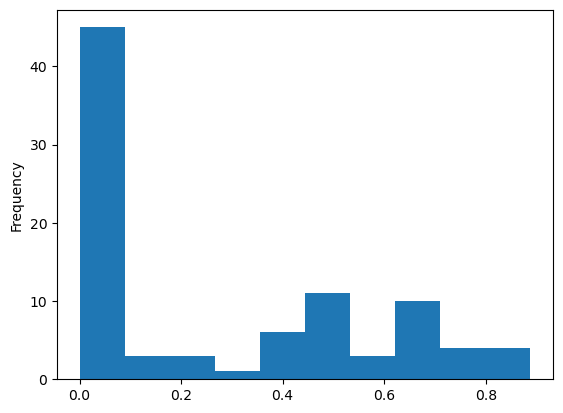

In [35]:
results_df.dice_tm.plot(kind='hist')

In [36]:
results_df.mhd.map(lambda x: x if x != np.inf else 68).mean()


35.6952889022205

##### Using the model trained on 21 classes (not enough predictions)


In [37]:
predictions_dir = os.path.join(data_dir, 'nnUNet_predictions', 'train_on_SD_predict_on_TD', 'train_on_Dataset004_21Classes', 'ADAM', 'imagesTr', '3d_fullres')
gt_vols_fp = glob.glob(os.path.join(ground_truth_dir, 'labelsTr', '*.nii.gz'))
pred_vols_fn = os.listdir(predictions_dir)
gt_vols_fp

['../../../../data/ADAM/Dataset005_ADAMBinaryAneurysmsOnly/labelsTr/10064F.nii.gz',
 '../../../../data/ADAM/Dataset005_ADAMBinaryAneurysmsOnly/labelsTr/10063B.nii.gz',
 '../../../../data/ADAM/Dataset005_ADAMBinaryAneurysmsOnly/labelsTr/10023.nii.gz',
 '../../../../data/ADAM/Dataset005_ADAMBinaryAneurysmsOnly/labelsTr/10041.nii.gz',
 '../../../../data/ADAM/Dataset005_ADAMBinaryAneurysmsOnly/labelsTr/10075F.nii.gz',
 '../../../../data/ADAM/Dataset005_ADAMBinaryAneurysmsOnly/labelsTr/10053F.nii.gz',
 '../../../../data/ADAM/Dataset005_ADAMBinaryAneurysmsOnly/labelsTr/10067F.nii.gz',
 '../../../../data/ADAM/Dataset005_ADAMBinaryAneurysmsOnly/labelsTr/10071F.nii.gz',
 '../../../../data/ADAM/Dataset005_ADAMBinaryAneurysmsOnly/labelsTr/10078B.nii.gz',
 '../../../../data/ADAM/Dataset005_ADAMBinaryAneurysmsOnly/labelsTr/10069B.nii.gz',
 '../../../../data/ADAM/Dataset005_ADAMBinaryAneurysmsOnly/labelsTr/10063F.nii.gz',
 '../../../../data/ADAM/Dataset005_ADAMBinaryAneurysmsOnly/labelsTr/10022.nii.

In [38]:
results_df = calculate_metrics(num_classes=21, aneurysm_class=4, gt_vols_fp=gt_vols_fp, pred_vols_fn=pred_vols_fn)

  0%|          | 0/90 [00:00<?, ?it/s]

No prediction for vol 10064F.nii.gz
No prediction for vol 10063B.nii.gz
No prediction for vol 10023.nii.gz
No prediction for vol 10041.nii.gz
No prediction for vol 10075F.nii.gz
No prediction for vol 10053F.nii.gz
No prediction for vol 10067F.nii.gz
No prediction for vol 10071F.nii.gz
No prediction for vol 10078B.nii.gz
No prediction for vol 10069B.nii.gz
No prediction for vol 10063F.nii.gz
No prediction for vol 10022.nii.gz


 13%|█▎        | 12/90 [00:06<00:41,  1.90it/s]


KeyboardInterrupt: 

In [ ]:
results_df.to_csv(os.path.join(data_dir, 'results', 'sd_usz_21classes__td_adam_treated_and_untreated_uias_trainset.csv'), index=False)

In [ ]:
results_df.dice_tm.mean()

In [ ]:
results_df.mhd.map(lambda x: x if x != np.inf else 68).mean()


# Continure running from here

### Only untreated UIAs

In [25]:
ground_truth_dir = os.path.join(data_dir, 'ADAM/Dataset007_ADAMBinaryUntreatedAneurysmsOnly')

#### Test set

##### Using the model trained on 3 classes


In [26]:
predictions_dir = os.path.join(data_dir, 'nnUNet_predictions', 'train_on_SD_predict_on_TD', 'train_on_Dataset003_3Classes', 'ADAM', 'imagesTs', '3d_fullres')
gt_vols_fp = glob.glob(os.path.join(ground_truth_dir, 'labelsTs', '*.nii.gz'))
pred_vols_fn = os.listdir(predictions_dir)
gt_vols_fp[0:4]

['../../../../data/ADAM/Dataset007_ADAMBinaryUntreatedAneurysmsOnly/labelsTs/10047B.nii.gz',
 '../../../../data/ADAM/Dataset007_ADAMBinaryUntreatedAneurysmsOnly/labelsTs/10048B.nii.gz',
 '../../../../data/ADAM/Dataset007_ADAMBinaryUntreatedAneurysmsOnly/labelsTs/10029.nii.gz',
 '../../../../data/ADAM/Dataset007_ADAMBinaryUntreatedAneurysmsOnly/labelsTs/10024.nii.gz']

In [27]:
results_df = calculate_metrics(num_classes=2, aneurysm_class=2, gt_vols_fp=gt_vols_fp, pred_vols_fn=pred_vols_fn)

100%|██████████| 23/23 [07:08<00:00, 18.63s/it]


In [28]:
results_df.to_csv(os.path.join(data_dir, 'results', 'sd_usz_3classes__td_adam_untreated_uias_testset.csv'), index=False)

In [29]:
results_df.dice_tm.mean()

0.28822340686684067

In [30]:
results_df.mhd.map(lambda x: x if x != np.inf else 68).mean()


37.032459948832866

In [31]:
results_df

,vol_name,dice_aneur_kostas,recall_aneur_kostas,precision_aneur_kostas,dice_tm,recall_tm,precision_tm,mhd
0,10047B.nii.gz,8.961748e-01,8.118812e-01,1.000000e+00,0.598540,0.811881,1.0,0.568552
1,10048B.nii.gz,9.808145e-01,9.623514e-01,1.000000e+00,0.764027,0.962351,1.0,0.534275
2,10029.nii.gz,1.000000e+00,1.000000e+00,1.000000e+00,0.335857,1.000000,1.0,1.778634
3,10024.nii.gz,9.858586e-01,9.721116e-01,1.000000e+00,0.444040,0.972112,1.0,1.014454
4,10068F.nii.gz,1.000000e+00,1.000000e+00,1.000000e+00,0.379762,1.000000,1.0,2.611038
5,10072F.nii.gz,0.000000e+00,0.000000e+00,1.000000e-12,0.000000,0.000000,0.0,inf
6,10037.nii.gz,0.000000e+00,0.000000e+00,1.000000e-12,0.000000,0.000000,0.0,79.611111
7,10068B.nii.gz,1.000000e+00,1.000000e+00,1.000000e+00,0.543921,1.000000,1.0,0.840614
8,10072B.nii.gz,0.000000e+00,0.000000e+00,1.000000e-12,0.000000,0.000000,0.0,44.182774
9,10047F.nii.gz,8.583333e-01,7.518248e-01,1.000000e+00,0.693603,0.751825,1.0,0.389302


##### Using the model trained on 21 classes


In [32]:
predictions_dir = os.path.join(data_dir, 'nnUNet_predictions', 'train_on_SD_predict_on_TD', 'train_on_Dataset004_21Classes', 'ADAM', 'imagesTs', '3d_fullres')
gt_vols_fp = glob.glob(os.path.join(ground_truth_dir, 'labelsTs', '*.nii.gz'))
pred_vols_fn = os.listdir(predictions_dir)
gt_vols_fp

['../../../../data/ADAM/Dataset007_ADAMBinaryUntreatedAneurysmsOnly/labelsTs/10047B.nii.gz',
 '../../../../data/ADAM/Dataset007_ADAMBinaryUntreatedAneurysmsOnly/labelsTs/10048B.nii.gz',
 '../../../../data/ADAM/Dataset007_ADAMBinaryUntreatedAneurysmsOnly/labelsTs/10029.nii.gz',
 '../../../../data/ADAM/Dataset007_ADAMBinaryUntreatedAneurysmsOnly/labelsTs/10024.nii.gz',
 '../../../../data/ADAM/Dataset007_ADAMBinaryUntreatedAneurysmsOnly/labelsTs/10068F.nii.gz',
 '../../../../data/ADAM/Dataset007_ADAMBinaryUntreatedAneurysmsOnly/labelsTs/10072F.nii.gz',
 '../../../../data/ADAM/Dataset007_ADAMBinaryUntreatedAneurysmsOnly/labelsTs/10037.nii.gz',
 '../../../../data/ADAM/Dataset007_ADAMBinaryUntreatedAneurysmsOnly/labelsTs/10068B.nii.gz',
 '../../../../data/ADAM/Dataset007_ADAMBinaryUntreatedAneurysmsOnly/labelsTs/10072B.nii.gz',
 '../../../../data/ADAM/Dataset007_ADAMBinaryUntreatedAneurysmsOnly/labelsTs/10047F.nii.gz',
 '../../../../data/ADAM/Dataset007_ADAMBinaryUntreatedAneurysmsOnly/label

In [33]:
results_df = calculate_metrics(num_classes=21, aneurysm_class=4, gt_vols_fp=gt_vols_fp, pred_vols_fn=pred_vols_fn)
results_df

 17%|█▋        | 4/23 [02:27<11:31, 36.41s/it]

No prediction for vol 10068F.nii.gz
No prediction for vol 10072F.nii.gz


 35%|███▍      | 8/23 [02:50<03:53, 15.56s/it]

No prediction for vol 10072B.nii.gz


 74%|███████▍  | 17/23 [09:18<04:59, 49.94s/it]

No prediction for vol 10077B.nii.gz


 83%|████████▎ | 19/23 [10:21<02:47, 41.77s/it]

No prediction for vol 10077F.nii.gz


 91%|█████████▏| 21/23 [11:02<01:06, 33.41s/it]

No prediction for vol 10060B.nii.gz


100%|██████████| 23/23 [11:54<00:00, 31.07s/it]


,vol_name,dice_aneur_kostas,recall_aneur_kostas,precision_aneur_kostas,dice_tm,recall_tm,precision_tm,mhd
0,10047B.nii.gz,9.849246e-01,9.702970e-01,1.000000e+00,0.592145,0.970297,1.0,0.671277
1,10048B.nii.gz,9.526116e-01,9.095112e-01,1.000000e+00,0.748166,0.909511,1.0,0.515659
2,10029.nii.gz,9.938144e-01,9.877049e-01,1.000000e+00,0.388084,0.987705,1.0,1.326434
3,10024.nii.gz,2.071429e-01,1.155379e-01,1.000000e+00,0.186495,0.115538,1.0,20.400906
4,10037.nii.gz,0.000000e+00,0.000000e+00,1.000000e-12,0.000000,0.000000,0.0,80.000923
5,10068B.nii.gz,1.000000e+00,1.000000e+00,1.000000e+00,0.434100,1.000000,1.0,1.553858
6,10047F.nii.gz,9.169961e-01,8.467153e-01,1.000000e+00,0.628726,0.846715,1.0,0.564183
7,10015.nii.gz,1.000000e-12,1.000000e-12,1.000000e-12,0.000000,0.000000,0.0,0.000000
8,10049F.nii.gz,0.000000e+00,0.000000e+00,1.000000e-12,0.000000,0.000000,0.0,inf
9,10028.nii.gz,0.000000e+00,0.000000e+00,1.000000e-12,0.000000,0.000000,0.0,inf


In [34]:
results_df.to_csv(os.path.join(data_dir, 'results', 'sd_usz_21classes__td_adam_untreated_uias_testset.csv'), index=False)

In [35]:
results_df.dice_tm.mean()

0.2572091712671168

In [36]:
results_df.mhd.map(lambda x: x if x != np.inf else 68).mean()


29.501166736590047

#### Train set
##### Using the model trained on 3 classes

In [37]:
predictions_dir = os.path.join(data_dir, 'nnUNet_predictions', 'train_on_SD_predict_on_TD', 'train_on_Dataset003_3Classes', 'ADAM', 'imagesTr', '3d_fullres')

gt_vols_fp = glob.glob(os.path.join(ground_truth_dir, 'labelsTr', '*.nii.gz'))
pred_vols_fn = os.listdir(predictions_dir)
gt_vols_fp

['../../../../data/ADAM/Dataset007_ADAMBinaryUntreatedAneurysmsOnly/labelsTr/10064F.nii.gz',
 '../../../../data/ADAM/Dataset007_ADAMBinaryUntreatedAneurysmsOnly/labelsTr/10063B.nii.gz',
 '../../../../data/ADAM/Dataset007_ADAMBinaryUntreatedAneurysmsOnly/labelsTr/10023.nii.gz',
 '../../../../data/ADAM/Dataset007_ADAMBinaryUntreatedAneurysmsOnly/labelsTr/10041.nii.gz',
 '../../../../data/ADAM/Dataset007_ADAMBinaryUntreatedAneurysmsOnly/labelsTr/10075F.nii.gz',
 '../../../../data/ADAM/Dataset007_ADAMBinaryUntreatedAneurysmsOnly/labelsTr/10053F.nii.gz',
 '../../../../data/ADAM/Dataset007_ADAMBinaryUntreatedAneurysmsOnly/labelsTr/10067F.nii.gz',
 '../../../../data/ADAM/Dataset007_ADAMBinaryUntreatedAneurysmsOnly/labelsTr/10071F.nii.gz',
 '../../../../data/ADAM/Dataset007_ADAMBinaryUntreatedAneurysmsOnly/labelsTr/10078B.nii.gz',
 '../../../../data/ADAM/Dataset007_ADAMBinaryUntreatedAneurysmsOnly/labelsTr/10069B.nii.gz',
 '../../../../data/ADAM/Dataset007_ADAMBinaryUntreatedAneurysmsOnly/labe

In [38]:
results_df = calculate_metrics(num_classes=2, aneurysm_class=2, gt_vols_fp=gt_vols_fp, pred_vols_fn=pred_vols_fn)
results_df

100%|██████████| 90/90 [36:31<00:00, 24.35s/it]


,vol_name,dice_aneur_kostas,recall_aneur_kostas,precision_aneur_kostas,dice_tm,recall_tm,precision_tm,mhd
0,10064F.nii.gz,9.992266e-01,9.984544e-01,1.000000e+00,0.667355,0.998454,1.0,16.886461
1,10063B.nii.gz,9.850384e-01,9.705179e-01,1.000000e+00,0.743136,0.970518,1.0,0.476742
2,10023.nii.gz,0.000000e+00,0.000000e+00,1.000000e-12,0.000000,0.000000,0.0,inf
3,10041.nii.gz,0.000000e+00,0.000000e+00,1.000000e-12,0.000000,0.000000,0.0,inf
4,10075F.nii.gz,9.846154e-01,9.696970e-01,1.000000e+00,0.166667,0.969697,1.0,4.020993
...,...,...,...,...,...,...,...,...
85,10007.nii.gz,1.000000e-12,1.000000e-12,1.000000e-12,0.000000,0.000000,0.0,0.000000
86,10011.nii.gz,1.000000e-12,1.000000e-12,1.000000e-12,0.000000,0.000000,0.0,inf
87,10032.nii.gz,0.000000e+00,0.000000e+00,1.000000e-12,0.000000,0.000000,0.0,inf
88,10052F.nii.gz,8.430232e-01,7.286432e-01,1.000000e+00,0.396988,0.728643,1.0,2.116431


In [39]:
results_df.to_csv(os.path.join(data_dir, 'results', 'sd_usz_21classes__td_adam_untreated_uias_trainset.csv'), index=False)

In [40]:
results_df.dice_tm.mean()

0.30287734474986794

In [41]:
results_df.dice_tm.median()

0.23434726148843765

<Axes: ylabel='Frequency'>

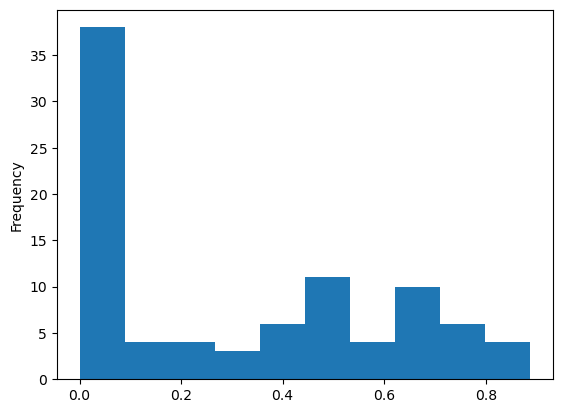

In [42]:
results_df.dice_tm.plot(kind='hist')

In [43]:
results_df.mhd.map(lambda x: x if x != np.inf else 68).mean()


24.36648787673488